In [1]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import os
import math
from tqdm import tqdm
from tqdm import trange
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random


In [2]:
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, path_dir, map_file, transform=None, shape = (100,100), device='cpu'):
        self.device = device
        self.paths = [] # create a list to hold all paths read from file
        # self.map = np.loadtxt(map_file, skiprows=2).reshape(shape)
        # self.map = self.map[np.newaxis, :, :]
        x = torch.tensor([]) # empty list to hold input series tensors
        num_paths = 0
        for filename in tqdm(os.listdir(path_dir)):
            num_paths += 1
            with open(os.path.join(path_dir, filename), 'r') as f: # open in readonly mode
                path_points_list = [] # a list to hold each point in a path
                self.flat_path = np.loadtxt(f) # load in the flat path from file
                self.path = np.asarray(self.flat_path, dtype=np.float32).reshape(len(self.flat_path)//2,2) #unflatten the path from the file
                # print(self.path)
                for point in self.path:
                    x = point[0]
                    y = point[1]
                    this_point = [x, y]
                    path_points_list.append(this_point)
            sequence = torch.tensor(path_points_list, dtype=torch.float)[:, :]
            self.paths.append(sequence)
                # self.path_tensor = self.convert_path(shape, self.path)

        # self.sequences = []
        # for path in range(len(path_list)):
        #    self.sequences.append((path_list[path] - mu)/sig)
        
        self.transform = transform
        print("Done!")

    def convert_path(self, map_dim, path):
        path_mat = np.zeros(map_dim, dtype=float)

        # Make the path continuous
        for i in range(path.shape[0] - 1):
            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            if (x1 < x2):
                x_dir = 1
            else:
                x_dir = -1

            if (y1 < y2):
                y_dir = 1
            else:
                y_dir = -1

            # Determine y from x
            if x2-x1 != 0:
                m = (y2-y1)/(x2-x1)
                while x != x2:
                    y = round(m*(x-x1) + y1)
                    path_mat[y,x] = 1
                    x += x_dir
            else:
                while x != x2:
                    path_mat[y1,x] = 1
                    x += x_dir


            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            # Determine x from y
            if y2-y1 != 0:
                m = (x2-x1)/(y2-y1)
                while y != y2:
                    x = round(m*(y-y1) + x1)
                    path_mat[y,x] = 1
                    y += y_dir
            else:
                while y != y2:
                    path_mat[y,x1] = 1
                    y += y_dir

        # print(path)
        # print(f'xs: {path[:,0]}')
        # print(f'ys: {path[:,1]}')
        # path_tensor = torch.tensor(path)
        # print(path_tensor)
        return path

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # x = np.float32(self.sequences[idx])
        # x = torch.Tensor(x).to(self.device)

        x = self.paths[idx]
        if self.transform:
            x = self.transform(x)
        
        return x

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# dataset name
MAP_NAME = '8x12_map_cropped'
DATASET = '60000_paths'
MAP_SHAPE = (64,64)
# loading info
ENCODER_PATH = f"checkpoints/encoder/"
DECODER_PATH = f"checkpoints/decoder/"
LOAD_EPOCH = 149
# training parameters
BATCH_SIZE = 1
train_dataset = PathsDataset(path_dir = f"./env/{MAP_NAME}/paths/{DATASET}/testing", map_file = f"./env/{MAP_NAME}/{MAP_NAME}.txt", shape = MAP_SHAPE, transform=None, device=device)
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

100%|██████████| 499/499 [00:00<00:00, 8320.51it/s]

Done!


In [4]:
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 5, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),     
            nn.Conv2d(64, 128, 7, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),  
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        return x

In [5]:
# class Decoder(nn.Module):
    
#     def __init__(self):
#         super().__init__()

#         self.unflatten = nn.Unflatten(dim=1, 
#         unflattened_size=(128, 1, 1))

#         self.decoder_conv = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, 7, 
#             stride=2, padding=0, output_padding=0),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 32, 5, encoded_map.to(device)
#             nn.ConvTranspose2d(32, 16, 5, 
#             stride=2, padding=1, output_padding=0),
#             nn.BatchNorm2d(16),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 1, 5, 
#             stride=2, padding=1, output_padding=1)
#         )
        
#     def forward(self, x):
#         x = self.unflatten(x)
#         x = self.decoder_conv(x)
#         x = torch.sigmoid(x)
#         return x

In [6]:
# create a new encoder
encoder = Encoder()
# decoder = Decoder()

In [7]:
#todo: load encoder checkpoint from file
checkpoint = torch.load(f'{ENCODER_PATH}epoch-{LOAD_EPOCH}.tar')
encoder.load_state_dict(checkpoint['model_state_dict'])

# checkpoint = torch.load(f'{DECODER_PATH}epoch-{LOAD_EPOCH}.tar')
# decoder.load_state_dict(checkpoint['model_state_dict'])

encoder.to(device)
# decoder.to(device)

encoder.eval()

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [8]:
#todo: run the map through the encoder and get an encoded map to use in the lstm
flat_map = np.loadtxt(f"./env/{MAP_NAME}/{MAP_NAME}.txt", skiprows=2)                                                   # load in the flat path from file
map = torch.tensor(np.asarray(flat_map, dtype=int).reshape(MAP_SHAPE[0], MAP_SHAPE[1])).to(device, dtype=torch.float)     # unflatten the map from the file

# plt.imshow(map.cpu())
# plt.show()

map_4d = map.unsqueeze(0).unsqueeze(0)

encoded_map = encoder(map_4d)#.squeeze()
# print(encoded_map.shape)
# print(encoded_map)


# decoded_map = decoder(encoded_map)

# new_map_2d = decoded_map.squeeze()

# plt.imshow(new_map_2d.cpu().detach().numpy())
# plt.show()

In [9]:
# train_target_paths = torch.Tensor()
# train_input_paths = torch.Tensor()
# train_goal_points = torch.Tensor()

# test_target_paths = torch.Tensor()
# test_input_paths = torch.Tensor()
# test_goal_points = torch.Tensor()

# # train_path_lens = []
# # test_path_lens = []

# nbr_eval_paths = 10

# for path in train_dataset[nbr_eval_paths:]:
#     input_path = path[:-1] #all points execpt last
#     target_path = path[1:]
#     goal_point = path[len(path)-1].unsqueeze(0)

#     train_target_paths = torch.cat((train_target_paths, target_path), 0)
#     train_input_paths = torch.cat((train_input_paths, input_path), 0)

#     for _ in range(len(path)-1):
#         train_goal_points = torch.cat((train_goal_points, goal_point), 0)

#     # train_path_lens.append(len(path))
#     # train_target_paths.append(target_path)
#     # train_input_paths.append(input_path)
#     # train_goal_points.append(goal_point)

# for path in train_dataset[:nbr_eval_paths]:
#     input_path = path[:-1] #all points execpt last five
#     target_path = path[1:]
#     goal_point = path[len(path)-1].unsqueeze(0)

#     test_target_paths = torch.cat((test_target_paths, target_path), 0)
#     test_input_paths = torch.cat((test_input_paths, input_path), 0)
    
#     for _ in range(len(path)-1):
#         test_goal_points = torch.cat((test_goal_points, goal_point), 0)
#     # test_target_paths.append(target_path)
#     # test_input_paths.append(input_path)
#     # test_goal_points.append(goal_point)

# train_target_paths = train_target_paths.to(device)
# train_input_paths = train_input_paths.to(device)
# train_goal_points = train_goal_points.to(device)

# test_target_paths = test_target_paths.to(device)
# test_input_paths = test_input_paths.to(device)
# test_goal_points = test_goal_points.to(device)



In [10]:
train_target_paths = []
train_input_paths = []
train_goal_points = torch.Tensor()

test_target_paths = []
test_input_paths = []
test_goal_points = torch.Tensor()

# train_path_lens = []
# test_path_lens = []

nbr_eval_paths = 10

for path in train_dataset[nbr_eval_paths:]:
    input_path = path[:-1] #all points execpt last
    target_path = path[1:]
    goal_point = path[len(path)-1].unsqueeze(0)

    train_target_paths.append(torch.Tensor(target_path).to(device))
    train_input_paths.append(torch.Tensor(input_path).to(device))
    train_goal_points = torch.cat((train_goal_points, goal_point), 0)

for path in train_dataset[:nbr_eval_paths]:
    input_path = path[:-1] #all points execpt last five
    target_path = path[1:]
    goal_point = path[len(path)-1].unsqueeze(0)

    test_target_paths.append(torch.Tensor(target_path).to(device))
    test_input_paths.append(torch.Tensor(input_path).to(device))
    test_goal_points = torch.cat((test_goal_points, goal_point), 0)

# train_target_paths = train_target_paths.to(device)
# train_input_paths = train_input_paths.to(device)
train_goal_points = train_goal_points.to(device)

# test_target_paths = test_target_paths.to(device)
# test_input_paths = test_input_paths.to(device)
test_goal_points = test_goal_points.to(device)



In [11]:
# print(train_input_paths.get_device())
# print(train_input_paths[3].get_device())
# print(encoded_map.get_device())

print(len(train_input_paths))
print(len(train_target_paths))
print(len(train_goal_points))

print(len(test_input_paths))

path_num = 3

print(f"path len: {len(train_input_paths[path_num])+1}")
print(train_input_paths[path_num])
print(train_target_paths[path_num])
print(train_goal_points[path_num])

489
489
489
10
path len: 9
tensor([[16., 59.],
        [20., 58.],
        [25., 58.],
        [30., 59.],
        [35., 59.],
        [39., 55.],
        [42., 52.],
        [47., 49.]], device='cuda:0')
tensor([[20., 58.],
        [25., 58.],
        [30., 59.],
        [35., 59.],
        [39., 55.],
        [42., 52.],
        [47., 49.],
        [47., 49.]], device='cuda:0')
tensor([47., 49.], device='cuda:0')


In [12]:
class MyLSTM(nn.Module):
  # hidden_d - the size of the hidden LSTM layers
  # map_d - the flattened/encoded map dimension
  def __init__(self, hidden_d=120, map_d=128, device="cpu"):
    self.hidden_d = hidden_d
    self.device = device
    super(MyLSTM, self).__init__()

    # map hidden layer
    self.lstm_map = nn.LSTMCell(input_size=map_d, hidden_size=self.hidden_d, device=self.device)

    # points hidden layer
    self.lstm_points = nn.LSTMCell(input_size=4, hidden_size=self.hidden_d, device=self.device)
    
    # "upper" hidden layer
    self.lstm1 = nn.LSTMCell(input_size=self.hidden_d*2, hidden_size=self.hidden_d, device=self.device)
    self.fc = nn.Linear(self.hidden_d, 2, device=self.device)


  def forward(self, goal_point, current_point, map):#, future=0):

    

    # Creation of cell state and hidden state for map hidden layer
    hidden_state_map = torch.zeros(1, self.hidden_d).to(self.device)
    cell_state_map = torch.zeros(1, self.hidden_d).to(self.device)
    # hidden_state_map = torch.zeros(self.hidden_d,1).to(self.device)
    # cell_state_map = torch.zeros(self.hidden_d,1).to(self.device)

    # Creation of cell state and hidden state for points hidden layer
    hidden_state_points = torch.zeros(1, self.hidden_d).to(self.device)
    cell_state_points = torch.zeros(1, self.hidden_d).to(self.device)

    # Creation of cell state and hidden state for "upper" hidden layer
    hidden_state_1 = torch.zeros(1, self.hidden_d).to(self.device)
    cell_state_1 = torch.zeros(1, self.hidden_d).to(self.device)

    outputs = []

    # initialize weights to random[-0.1, 0.1) (need to update initialzation to match paper)
    # weights initialization
    torch.nn.init.xavier_normal_(hidden_state_map)
    torch.nn.init.xavier_normal_(cell_state_map)

    torch.nn.init.xavier_normal_(hidden_state_points)
    torch.nn.init.xavier_normal_(cell_state_points)

    torch.nn.init.xavier_normal_(hidden_state_1)
    torch.nn.init.xavier_normal_(cell_state_1)

    # Concatenate start and goal
    points = torch.cat([current_point, goal_point], 0).unsqueeze(0)

    hidden_state_map, cell_state_map = self.lstm_map(map, (hidden_state_map, cell_state_map))
    hidden_state_points, cell_state_points = self.lstm_points(points, (hidden_state_points, cell_state_points))

    # Concatenate the output the lstm layer output from points and map into a single input to the final "upper" hidden layer
    final_layer_input = torch.cat([hidden_state_map, hidden_state_points], 1)
    hidden_state_1, cell_state_1 = self.lstm1(final_layer_input, (hidden_state_1, cell_state_1))
      
    # Last hidden state is passed through a fully connected neural net
    output = self.fc(hidden_state_1)	
    # print(f'out: {output}')
    outputs.append(output)

    outputs = torch.cat(outputs, dim=0)
    
    return outputs

epoch: 0
1208.6129150390625
1225.68212890625
2302.11767578125
1876.96044921875
987.0958251953125
1714.6927490234375
193.1817626953125
1716.8515625
1571.1483154296875
1492.27734375
1262.08935546875
1371.8392333984375
543.3426513671875
478.66943359375
147.67025756835938
1015.5057373046875
1015.3233032226562
825.397216796875
895.9741821289062
363.31414794921875
504.29840087890625
342.19061279296875
324.4329833984375
1378.1898193359375
368.1580810546875
860.6522216796875
1786.86474609375
888.9166870117188
67.22212982177734
986.479736328125
707.0890502929688
676.2896728515625
465.058837890625
1712.0655517578125
1170.8150634765625
751.5388793945312
386.68585205078125
87.32301330566406
589.419189453125
1329.3773193359375
1673.833740234375
263.18994140625
1444.7724609375
713.4691162109375
941.1224975585938
141.74476623535156
803.2166748046875
771.79443359375
501.06591796875
2117.25
1902.77880859375
32.655574798583984
720.4957885742188
1890.06005859375
523.9467163085938
263.9377136230469
484.99

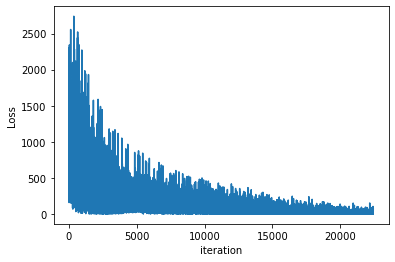

In [13]:
rnn = MyLSTM(device=device)
loss = []
criterion = nn.MSELoss()
opt = torch.optim.Adam(rnn.parameters(), lr=0.0001)
# n_epochs = 1000
n_epochs = 8
for e in range(n_epochs):
  print(f'epoch: {e}')
  for path_num in range(len(train_input_paths)):                # go through each path
    for point_num in range(len(train_input_paths[path_num])):   # go through each point

      # predict next point:
      pred = rnn(train_goal_points[path_num], train_input_paths[path_num][point_num], encoded_map).squeeze()

      # calculate loss:
      err = criterion(pred, train_target_paths[path_num][point_num])
      opt.zero_grad()
      err.backward(retain_graph=True)
      opt.step()

      loss.append(err.item())

      # print loss:
      if point_num % 100 == 0:  
        print(err.item())

plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

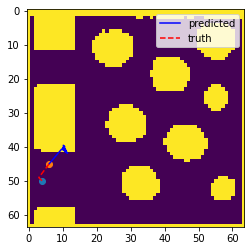

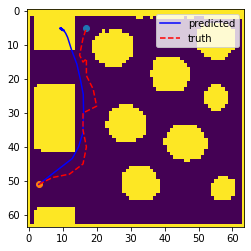

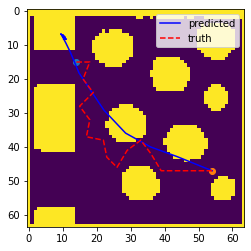

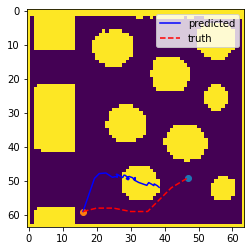

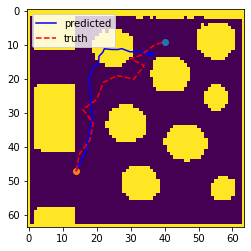

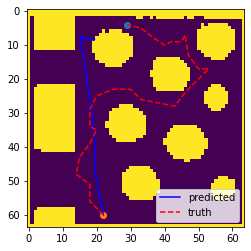

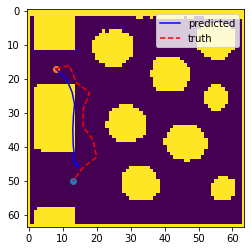

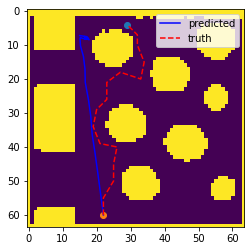

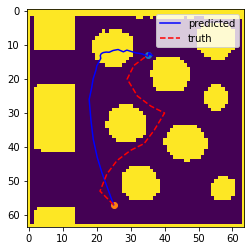

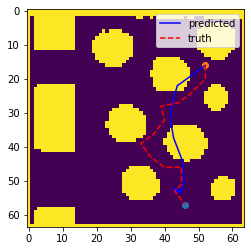

In [14]:
# prediction loop
for path_idx in range(10):
    # path_idx = 2
    num_pts = 30
    start_point = train_input_paths[path_idx][0]
    generated_pts = []
    with torch.no_grad():
        
        # add start point:
        generated_pts.append(start_point.cpu().detach().numpy().tolist())
        prev_pred = start_point

        # predict other points:
        for i in range(num_pts):
            pred = rnn(train_goal_points[path_idx], prev_pred, encoded_map).squeeze()
            prev_pred = pred
            generated_pts.append(pred.cpu().detach().numpy().tolist())

    xs = []
    ys = []

    for x,y in generated_pts:
        xs.append(x)
        ys.append(y)

    plt.imshow(map.cpu())
    # plt.plot(xs, ys, color='k', label = "input")
    plt.plot(xs, ys, color='b', label = "predicted")
    plt.plot(train_dataset[10+path_idx][:,0], train_dataset[10+path_idx][:,1], color='r', label = "truth", linestyle='dashed')
    plt.scatter(train_goal_points[path_idx][0].cpu(), train_goal_points[path_idx][1].cpu())
    plt.scatter(start_point[0].cpu(), start_point[1].cpu())
    plt.legend()
    plt.show()

In [15]:
start_points_list = []
coords_list = []

num_points = 30 # num points to predict for each path
paths_to_gen = 6 # num paths to generate

for x in range(paths_to_gen):
    start_x = 20
    start_y = 50
    goal_x = 40
    goal_y = 10
    start_point = torch.from_numpy(np.asarray([start_x,start_y])).float().to(device)
    goal_point = torch.from_numpy(np.asarray([goal_x,goal_y])).float().to(device)
    points = []
    with torch.no_grad():
        pred = start_point
        points.append(pred.cpu().detach().numpy().tolist())
        for point in range(num_points):
            pred = rnn(goal_point, pred, encoded_map).squeeze()
            points.append(pred.cpu().detach().numpy().tolist())
        # points = torch.cat(points, dim=0)

    coords_list.append(points)

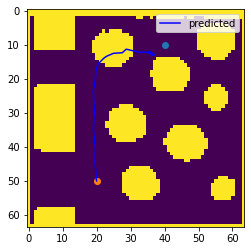

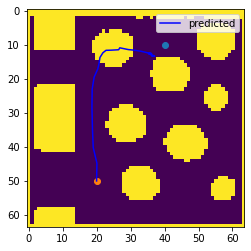

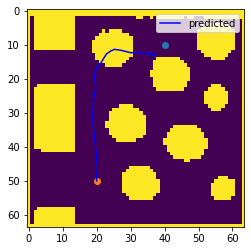

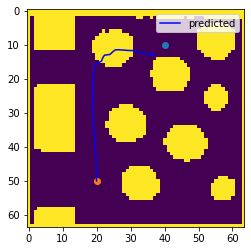

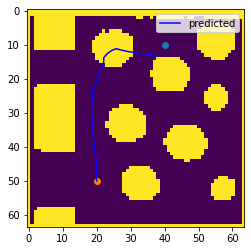

In [16]:
for x in range(5):
    xs = []
    ys = []
    for x,y in coords_list[x]:
        xs.append(x)
        ys.append(y)

    plt.imshow(map.cpu())
    plt.plot(xs, ys, color='b', label = "predicted")
    plt.scatter(goal_point[0].cpu(), goal_point[1].cpu())
    plt.scatter(start_point[0].cpu(), start_point[1].cpu())
    plt.legend()
    plt.show()